<a href="https://colab.research.google.com/github/Anjaneyavarma/cat-vs-dog_classification/blob/master/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#install pillow
!pip install -q pillow==4.1.1

In [0]:
### Install Pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format='retina'

import json
import torch
import PIL
import copy
import time
import numpy as np
from collections import OrderedDict
from torch import nn, optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms, models, utils
from PIL import Image

In [0]:
!pip install -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data_dir = '/content/drive/My Drive/cat-vs-dog project/Cat_Dog_data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'



In [0]:
# TODO: Define your transforms for the training and validation sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),                                                                                                             
                                          transforms.RandomHorizontalFlip(),                                               
                                          transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485,0.456,0.406),
                                                               (0.229,0.224,0.225))])    
                                                                                                                                         
                                                                                                                         
testing_transforms = transforms.Compose([transforms.Resize(255), 
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485,0.456,0.406),
                                                                 (0.229,0.224,0.225))])
                                       
                                       
### Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform =training_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform =testing_transforms)

### Using the image datasets and the transforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(training_dataset, batch_size =64, shuffle =True)
testloader = torch.utils.data.DataLoader(testing_dataset, batch_size =64)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
for param in model.parameters():
    param.requires_grad_(False)
    

In [0]:
model.classifier = nn.Sequential(OrderedDict([
                                ('dropout1', nn.Dropout(p=0.1)),
                                ('fc1', nn.Linear(1024, 512)),
                                ('relu1', nn.ReLU()),
                                ('dropout2', nn.Dropout(p=0.1)),
                                ('fc2', nn.Linear(512, 2)),
                                ('output', nn.LogSoftmax(dim=1)) 
                                ])) 

In [59]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [62]:
  epochs = 1
  steps = 0
  print_every = 5
  print("training process Intializing.....\n")
  for epoch in range(epochs):
      for inputs, labels in trainloader:
          steps += 1
          running_loss = 0
          # Move input and label tensors to the default device
          inputs, labels = inputs.to(device), labels.to(device)
       
          optimizer.zero_grad()
        
          logps = model.forward(inputs)
          loss = criterion(logps, labels)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()
        
          if steps % print_every == 0:
              test_loss = 0
              accuracy = 0
              model.eval()
              with torch.no_grad():
                  for inputs, labels in testloader:
                      inputs, labels = inputs.to(device), labels.to(device)
                      logps = model.forward(inputs)
                      batch_loss = criterion(logps, labels)
                      
                      test_loss += batch_loss.item()
                    
                      # Calculate accuracy
                      ps = torch.exp(logps)
                      top_p, top_class = ps.topk(1, dim=1)
                      equals = top_class == labels.view(*top_class.shape)
                      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
              print("Epoch {}/{}.. ".format(epoch+1, epochs),
                    "Training loss: {:.3f}.. ".format(running_loss / len(trainloader)),  
                    "test loss: {:.3f}..".format(test_loss / len(testloader)),
                    "test accuracy: {:.3f}..".format(accuracy / len(testloader)))
   
              
              model.train()

print("\n  training process completed")

training process Intializing.....

Epoch 1/1..  Training loss: 0.000..  test loss: 0.035.. test accuracy: 0.986..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.039.. test accuracy: 0.984..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.040.. test accuracy: 0.985..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.039.. test accuracy: 0.985..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.045.. test accuracy: 0.985..
Epoch 1/1..  Training loss: 0.001..  test loss: 0.062.. test accuracy: 0.974..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.045.. test accuracy: 0.983..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.045.. test accuracy: 0.981..
Epoch 1/1..  Training loss: 0.001..  test loss: 0.040.. test accuracy: 0.985..
Epoch 1/1..  Training loss: 0.000..  test loss: 0.043.. test accuracy: 0.984..
Epoch 1/1..  Training loss: 0.001..  test loss: 0.039.. test accuracy: 0.985..


KeyboardInterrupt: ignored

In [0]:
image_path = train_dir + '/cat/cat.2.jpg'

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image = Image.open(image_path)
    
    image_transforms = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],
                                                                [0.229,0.224,0.225])])  
    
    image = image_transforms(image)
    image = np.array(image)
        
    print(image.shape, '\n') 
    
    return image

In [190]:
image=process_image(image_path)

(3, 224, 224) 



In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.grid(False)
    
    return ax

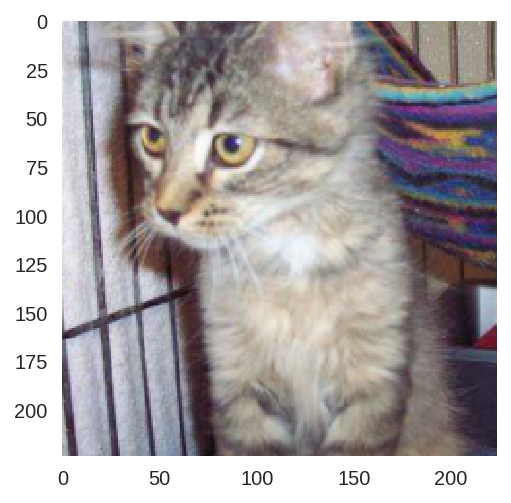

In [192]:
imshow(image, ax=None, title=None)

Representation of classes names

1 = 'dog'
0 = 'cat'



In [0]:
def predict(image_path,model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
         
    model.eval()
    model.to(device) 
    
    with torch.no_grad():      
     
      image = process_image(image_path)  
      image = torch.from_numpy(image).type(torch.FloatTensor)
           
      image = image.unsqueeze(0)
      image = image.to(device)
     
      output = model.forward(image)
      preds = torch.exp(output)
        
      probs, indices = torch.topk(preds, topk, dim =1)   
      probs = [float(prob) for prob in probs[0]]
      print("Indices:\n", indices, '\n')
      
            
      return probs

In [194]:
probs=predict(image_path,model,topk=2)
print("Probs:\n", probs, '\n') 

(3, 224, 224) 

Indices:
 tensor([[0, 1]], device='cuda:0') 

Probs:
 [0.9998030662536621, 0.00019683045684359968] 



(3, 224, 224) 

(3, 224, 224) 

Indices:
 tensor([[0, 1]], device='cuda:0') 



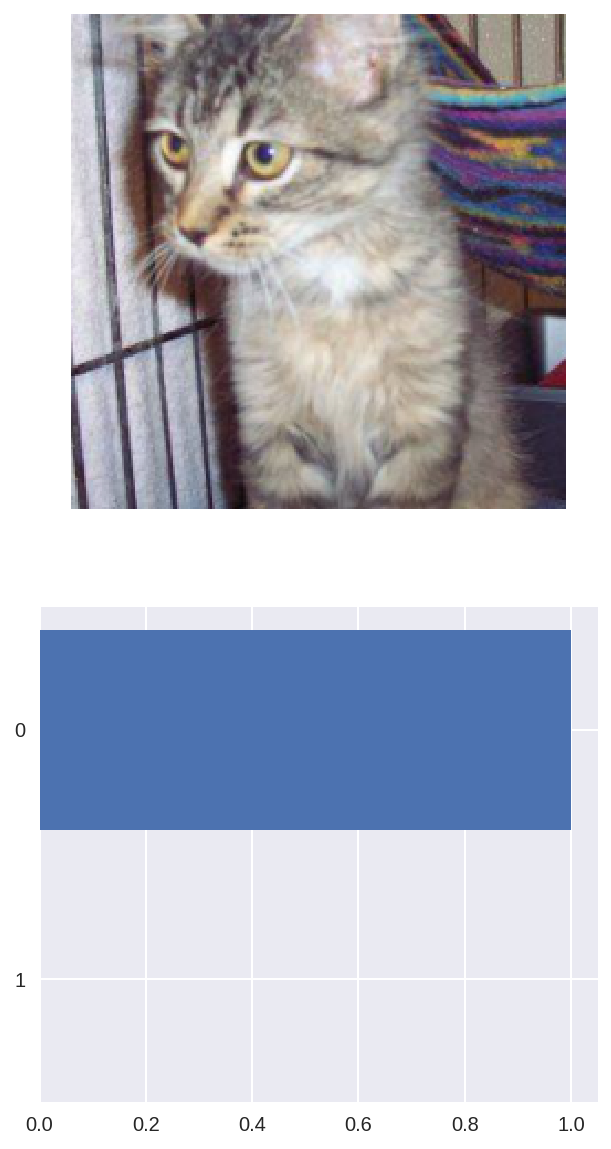

In [198]:

image_path = train_dir + "/cat/cat.2.jpg"

f = plt.figure(figsize=(5,10))

ax = f.add_subplot(2,1,1)
pil_image = Image.open(train_dir + "/cat/cat.2.jpg")
np_image = process_image(pil_image)
imshow(np_image, ax=ax)
ax.set_yticks([])
ax.set_xticks([])

plt.subplot(2,1,2)
probs = predict(image_path, model, topk=2)
classes_name = [classes[class_i] for class_i in classes]
plt.barh(range(len((classes_name))), probs)
plt.yticks(range(len(classes_name)),classes_name)
plt.gca().invert_yaxis()

